# Importing Dependencies
---

In [1]:
from time import time

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, box
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN, KMeans

In [3]:
import coriolis_module

# Importing Datasets
---

In [4]:
# Loading world data for the basemap
world_path = geodatasets.get_path("naturalearth.land")
world = gpd.read_file(world_path)

# Flights and Airports
---
Flights found at (https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023?select=flights_sample_3m.csv)

Airports found at (https://www.kaggle.com/datasets/nancyalaswad90/us-airports)

In [5]:
fl_df = pd.read_csv("data/flights_sample_3m.csv").astype(
    {
        "FL_DATE": "datetime64[ns]", 
        "AIRLINE": "category", 
        "AIRLINE_DOT": "category", 
        "AIRLINE_CODE": "category", 
        "ORIGIN": "category", 
        "ORIGIN_CITY": "category", 
        "DEST": "category",
        "DEST_CITY": "category", 
        "CANCELLED": "bool",
        "CANCELLATION_CODE": "category", 
        "DIVERTED": "bool",
        
    }
)

In [6]:
fl_df.columns

Index(['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE',
       'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_CARRIER',
       'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY',
       'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [7]:
len(fl_df)

3000000

In [8]:
ap_df = pd.read_csv("data/airports.csv").astype(
    {
        "IATA": "category",
        "AIRPORT": "category",
        "CITY": "category",
        "STATE": "category",
        "COUNTRY": "category",
    }
)

In [9]:
ap_df.columns

Index(['IATA', 'AIRPORT', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'], dtype='object')

In [10]:
len(ap_df)

341

# Plotting Airport Geolocations
---

In [11]:
fl_df_airports = set(fl_df["ORIGIN"].unique()).union(set(fl_df["DEST"].unique()))
ap_df_airports = set(ap_df["IATA"].unique())

missing_airports = fl_df_airports.difference(ap_df_airports)

In [12]:
ap_df = ap_df[ ~ap_df["IATA"].isin(missing_airports) ]

In [13]:
ap_geometry = [Point(xy) for xy in zip(ap_df["LONGITUDE"], ap_df["LATITUDE"])]
ap_gdf = gpd.GeoDataFrame(ap_df, geometry=ap_geometry)

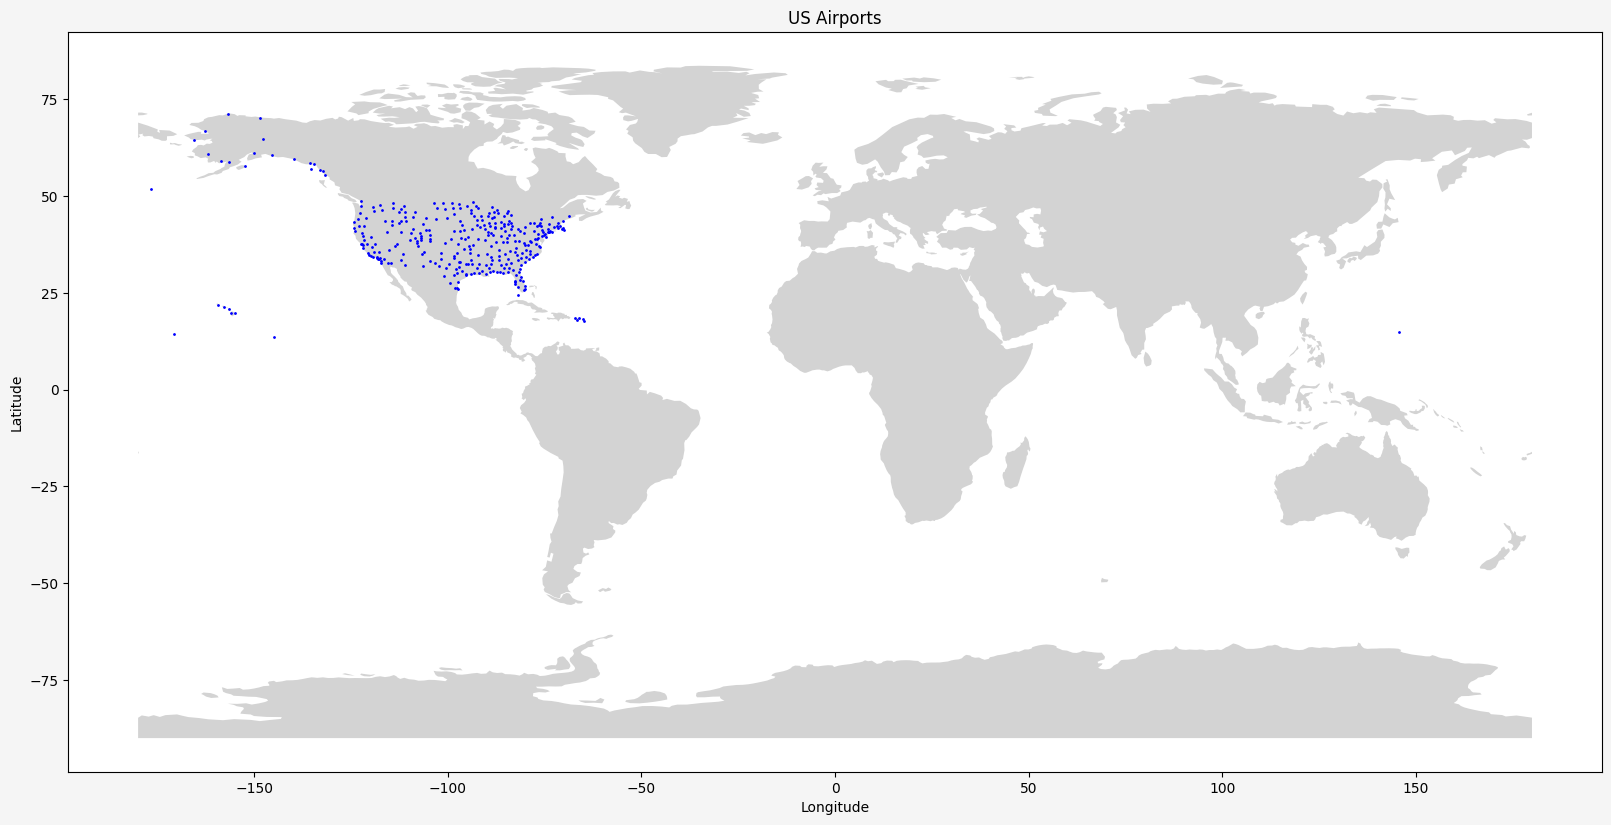

In [14]:
# Creating the figure and axes with Matplotlib
fig, ax = plt.subplots(figsize=(16, 9), facecolor="whitesmoke", layout="constrained")

# Plotting the world basemap on the axes
world.plot(ax=ax, color="lightgray")

# Plotting gdf
ap_gdf.plot(ax=ax, marker="o", color="blue", markersize=1)

# Adding titles, labels, etc...
ax.set_title("US Airports")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

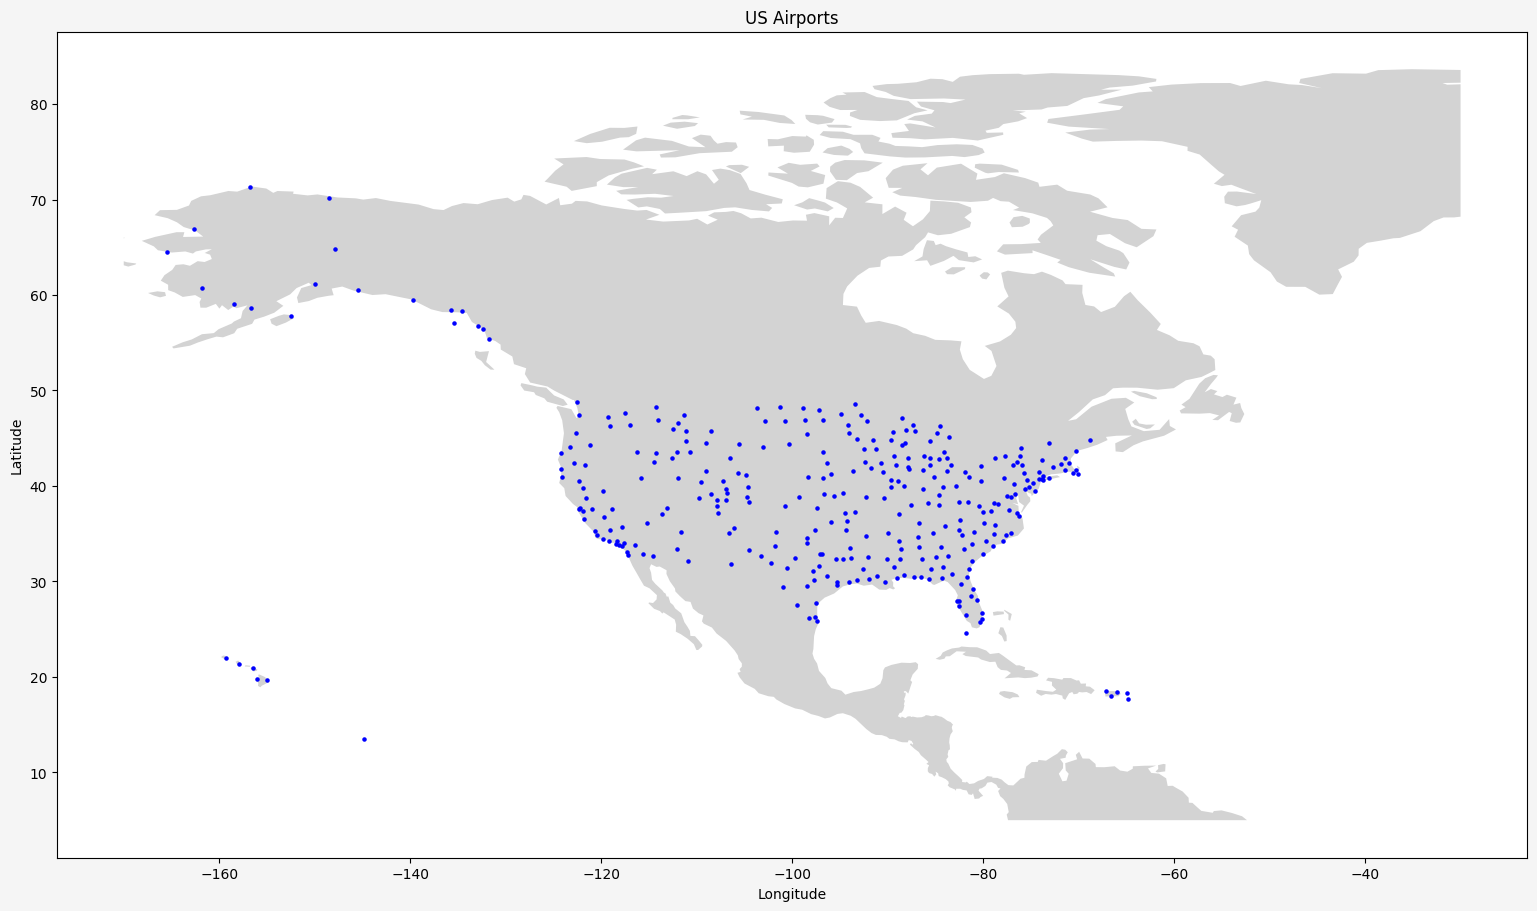

In [15]:
# USA (roughly)
north_america_box = box(-170, 5, -30, 85)  # (min_lon, min_lat, max_lon, max_lat)

# Clipping the world land data to the bounding box of North America
north_america = world.clip(north_america_box)

# Define plot
fig, ax = plt.subplots(figsize=(16, 9), facecolor="whitesmoke", layout="constrained")

# Plotting northamerica
north_america.plot(ax=ax, color="lightgray")

# Plotting gdf_origin on top of it  (GeoDataFrame for airport origins)
ap_gdf[
    (85 >= ap_gdf["LATITUDE"]) & 
    (ap_gdf["LATITUDE"] >= 5) & 
    (-30 >= ap_gdf["LONGITUDE"]) &
    (ap_gdf["LONGITUDE"] >= -170)
].plot(ax=ax, marker="o", color="blue", markersize=5)

ax.set_title("US Airports")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

In [16]:
del world
del ap_geometry
del ap_gdf
del north_america_box
del north_america

# Merging in airport locations
---

In [17]:
# Dropping rows with missing_airports
fl_df = fl_df[~fl_df["ORIGIN"].isin(missing_airports)]
fl_df = fl_df[~fl_df["DEST"].isin(missing_airports)]

In [18]:
# Merge to add geographical data
fl_df = pd.merge(fl_df, ap_df[["IATA", "LATITUDE", "LONGITUDE"]], 
                      left_on="ORIGIN", right_on="IATA", how="left")

fl_df = pd.merge(fl_df, ap_df[["IATA", "LATITUDE", "LONGITUDE"]], 
                      left_on="DEST", right_on="IATA", how="left", suffixes=("_ORIGIN", "_DEST"))

In [19]:
# Dropping redundand columns
fl_df = fl_df.drop(["IATA_ORIGIN", "IATA_DEST"], axis=1)

# Timeconversion
---

In [20]:
def convert_time(df, time_columns):
    """ Convert integer time columns to HH:MM format """
    for col in time_columns:
        # Handle missing values and convert times
        df[col] = df[col].fillna(0).astype(int).apply(lambda x: f"{x//100:02d}:{x%100:02d}")
        # Adjust for hours == 24
        df[col] = df[col].replace("24:00", "00:00")
    return df

In [21]:
# Drop cancelled flights
fl_df = fl_df[~fl_df["CANCELLED"]]

In [22]:
# Applythe time conversion
fl_df = convert_time(fl_df, ["WHEELS_OFF", "WHEELS_ON"])

In [23]:
# Set up datetime columns for wheels off and wheels on
fl_df["WHEELS_OFFDT"] = pd.to_datetime(fl_df["FL_DATE"].astype(str) + " " + fl_df["WHEELS_OFF"])
fl_df["WHEELS_ONDT"] = pd.to_datetime(fl_df["FL_DATE"].astype(str) + " " + fl_df["WHEELS_ON"])

In [24]:
# Drop original time columns
fl_df = fl_df.drop(["WHEELS_OFF", "WHEELS_ON"], axis=1)

# Visualise Timestamps
---

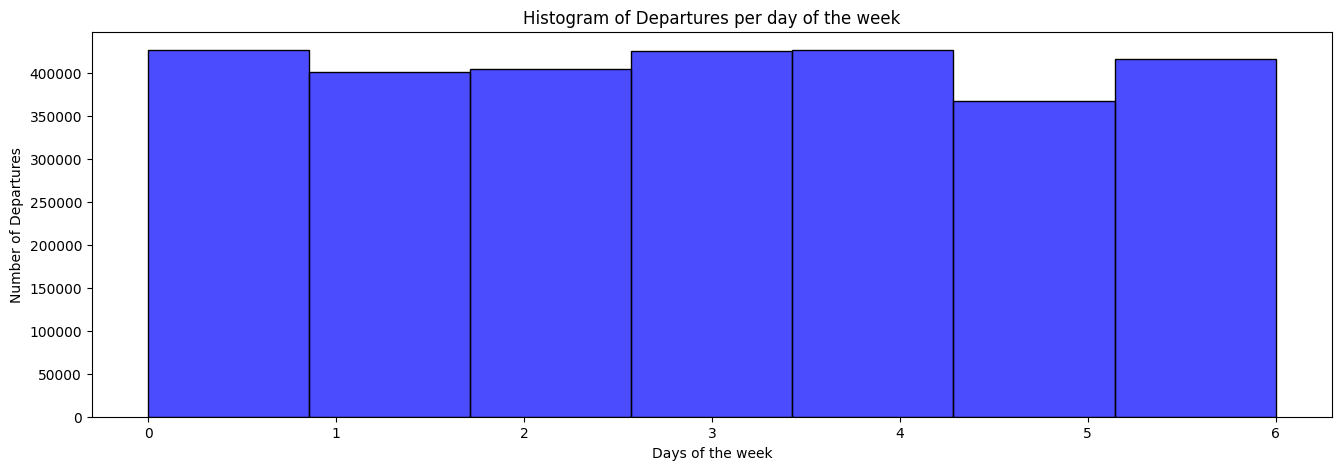

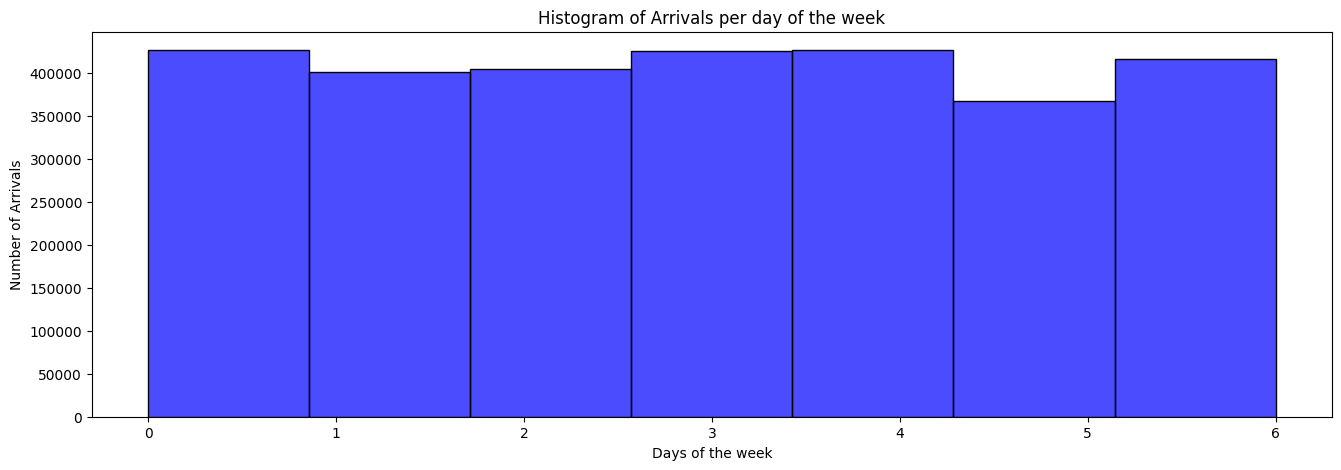

In [25]:
# Histogram of departures per day of the week
plt.figure(figsize=(16, 5))
sns.histplot(fl_df["WHEELS_OFFDT"].dt.dayofweek, bins=7, kde=False, color="blue", alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Departures per day of the week")
plt.xlabel("Days of the week")
plt.ylabel("Number of Departures")

# Showing the plot
plt.show()

# Histogram of arrivals per day of the week
plt.figure(figsize=(16, 5))
sns.histplot(fl_df["WHEELS_ONDT"].dt.dayofweek, bins=7, kde=False, color="blue", alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Arrivals per day of the week")
plt.xlabel("Days of the week")
plt.ylabel("Number of Arrivals")

# Showing the plot
plt.show()

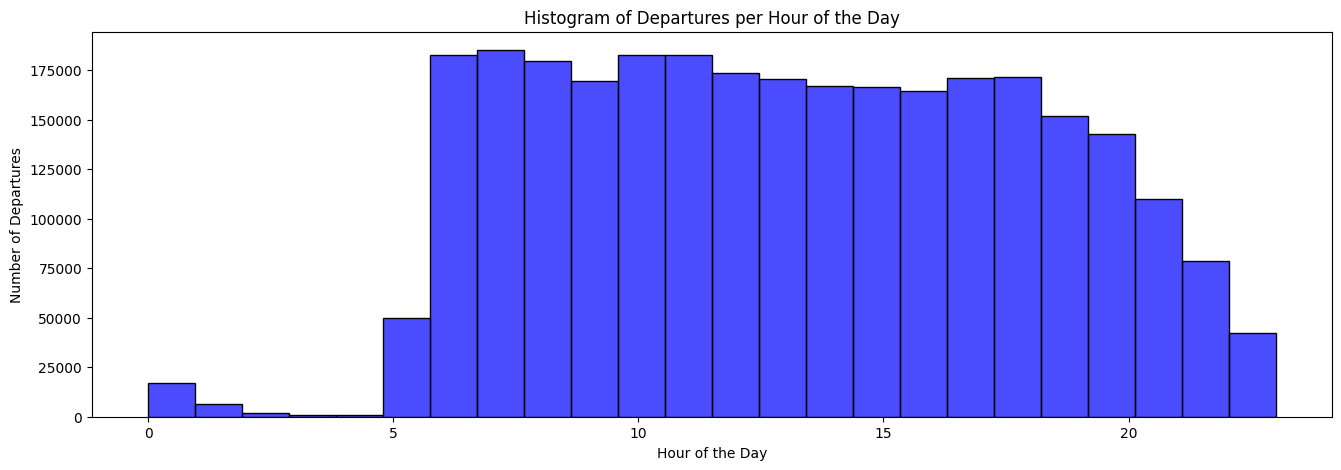

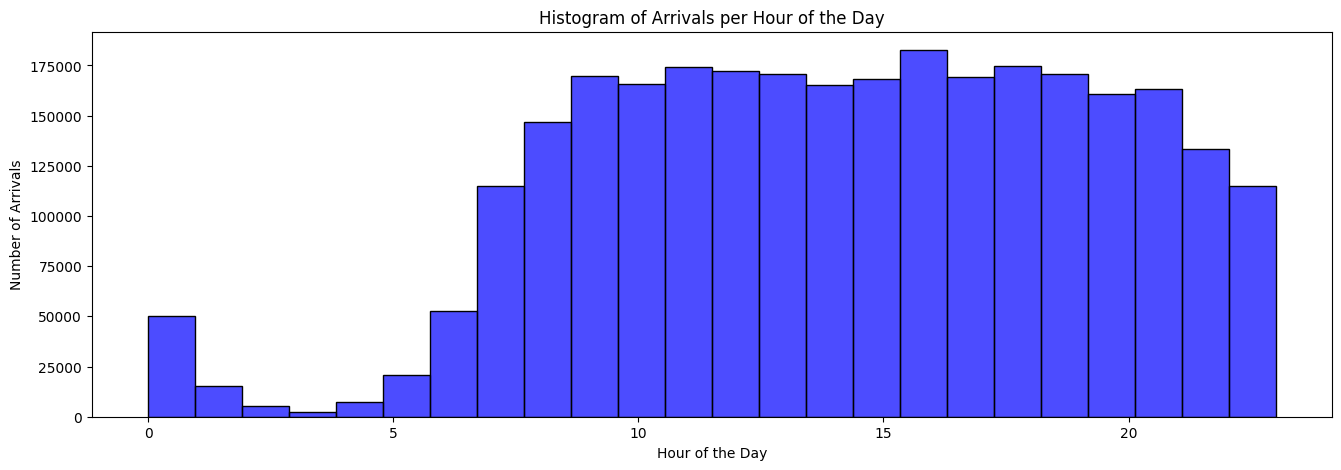

In [26]:
# Histogram of departures per hour of the day
plt.figure(figsize=(16, 5))
sns.histplot(fl_df["WHEELS_OFFDT"].dt.hour, bins=24, kde=False, color='blue', alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Departures per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Departures")

# Showing the plot
plt.show()

# Histogram of arrivals per hour of the day
plt.figure(figsize=(16, 5))
sns.histplot(fl_df["WHEELS_ONDT"].dt.hour, bins=24, kde=False, color='blue', alpha=0.7)

# Adding titles and labels
plt.title("Histogram of Arrivals per Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Arrivals")

# Showing the plot
plt.show()

# Calculate Airtime
---

In [27]:
# Calculate airtime based on time between wheels off and wheels on timestamps
fl_df["WOWO_AIR_TIME"] = fl_df["WHEELS_ONDT"] - fl_df["WHEELS_OFFDT"]

In [28]:
# Drop flights where airtime makes no sense
fl_df = fl_df[(fl_df["WOWO_AIR_TIME"].dt.total_seconds() > 0)]

# Calculate haversine distances 
---

In [29]:
# Calculation of Earth's radius at a given latitude
def radius_at_latitude(lat):
    """
    Calculates the Earth's radius at a specific latitude.
    
    Args:
        lat (float): Latitude in degrees.

    Returns:
        float: The interpolated Earth radius at the given latitude, in kilometers.
    """
    # Convert latitude from degrees to radians
    lat_rad = np.radians(lat)
    
    # Earth's polar radius = 6371.0 km, equatorial radius = 6378.137 km
    # Interpolating between the two based on the latitude
    return 6371.0 * (1 - 0.5 * (1 - np.cos(lat_rad))) + \
           6378.137 * (0.5 * (1 - np.cos(lat_rad)))

In [30]:
# Haversine formula to calculate the great-circle distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points 
    on the Earth using the Haversine formula.

    Args:
        lat1, lon1 (float): Latitude and Longitude of the first point in degrees.
        lat2, lon2 (float): Latitude and Longitude of the second point in degrees.

    Returns:
        float: The distance between the two points in kilometers.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # Get Earth's radius based on average latitude of the two points
    avg_lat = np.degrees((lat1 + lat2) / 2)
    r = radius_at_latitude(avg_lat)
    
    # Distance in kilometers
    return c * r

In [31]:
fl_df["HAVERSINE"] = haversine(
    fl_df["LATITUDE_ORIGIN"],
    fl_df["LONGITUDE_ORIGIN"],
    fl_df["LATITUDE_DEST"],
    fl_df["LONGITUDE_DEST"],
)

# Compare given with calculated distances
---

In [32]:
# Conversion from Miles to Kilometers
fl_df["DISTANCE"] = fl_df["DISTANCE"] * 1.609344

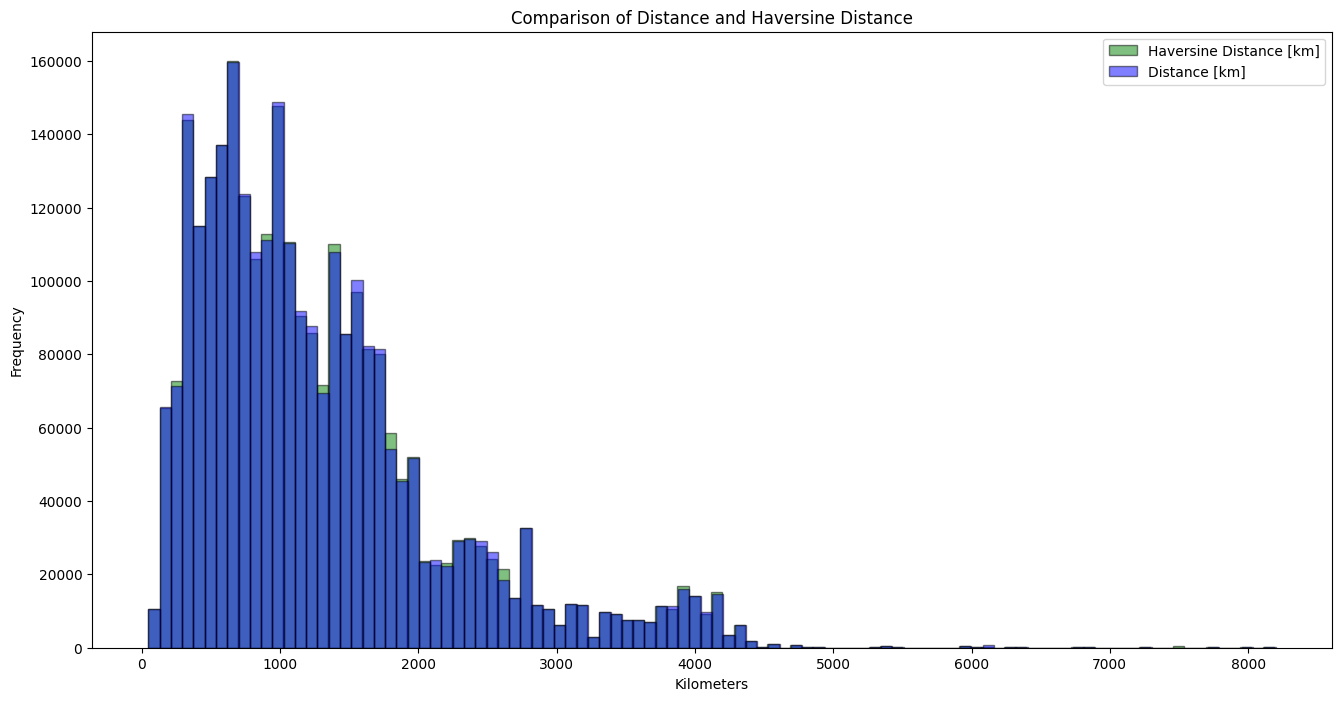

In [33]:
# Overlapping Histograms of Distance and Haversine Distance
plt.figure(figsize=(16, 8))

plt.hist(fl_df["HAVERSINE"], bins=100, alpha=0.5, label="Haversine Distance [km]", color="green", edgecolor="black")
plt.hist(fl_df["DISTANCE"], bins=100, alpha=0.5, label="Distance [km]", color="blue", edgecolor="black")

plt.title("Comparison of Distance and Haversine Distance")
plt.xlabel("Kilometers")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

# Calculate coriolis drift distances
---

In [34]:
fl_df["AVERAGE_VEL"] = fl_df["HAVERSINE"] / fl_df["WOWO_AIR_TIME"].dt.total_seconds()

In [35]:
# Applying direction vector function row-wise
directions = fl_df.apply(
    lambda row: coriolis_module.direction_vector(
        row["LATITUDE_ORIGIN"], 
        row["LONGITUDE_ORIGIN"], 
        row["LATITUDE_DEST"], 
        row["LONGITUDE_DEST"]
    ), axis=1
)

In [36]:
# Split the resulting direction vectors into separate columns
fl_df["X_DIR"] = fl_df["AVERAGE_VEL"] * directions.apply(lambda x: x[0])
fl_df["Y_DIR"] = fl_df["AVERAGE_VEL"] * directions.apply(lambda x: x[1])
fl_df["Z_DIR"] = fl_df["AVERAGE_VEL"] * directions.apply(lambda x: x[2])

In [37]:
def cpp_total_drift(row, airtime, num_steps=100):
    """
    Calculates the total drift distance due to Coriolis effect for a given row

    Args:
        row (pd.Series): A row from the DataFrame containing required data:
                         - 'X_DIR', 'Y_DIR', 'Z_DIR': Direction components.
                         - 'LATITUDE_ORIGIN', 'LATITUDE_DEST': Latitude values.
        airtime (float): Total time over which the drift occurs (in seconds).
        num_steps (int): Number of steps for integration (default is 100).

    Returns:
        float: Total drift distance magnitude at the last time step (in kilometers).
    """

    coriolis_accelerations = coriolis_module.coriolis_acc(
        row["LATITUDE_ORIGIN"], row["LATITUDE_DEST"], 
        row["X_DIR"], row["Y_DIR"], row["Z_DIR"],
        airtime, num_steps
    )

    coriolis_velocity = coriolis_module.calculate_velocities(coriolis_accelerations, airtime, num_steps)
    coriolis_drift_distance = coriolis_module.calculate_drift_distances(coriolis_velocity, airtime, num_steps)

    return np.linalg.norm(coriolis_drift_distance[-1])

In [38]:
start_time = time()

In [39]:
# Applying function row by row
fl_df["COR_DRIFT"] = fl_df.apply(
    lambda row: cpp_total_drift(
        row, row["WOWO_AIR_TIME"].total_seconds(), num_steps=100  # adjust num_steps for precision
    ), axis=1
)

In [40]:
end_time = time()

In [41]:
print(f"{end_time - start_time:,.2f} : seconds")

589.75 : seconds


In [42]:
# Compute total sum, ratio and percentage of drift and haversine distance
hs_dist = fl_df["HAVERSINE"].sum()
td_dist = fl_df["COR_DRIFT"].sum()

tdhs_ratio = td_dist/hs_dist

print(f"{hs_dist:,.2f} km: Total haversine distance.")
print(f"{td_dist:,.2f} km: Total drift distance caused by coriolis effect of earths rotation.")
print()
print(f"{tdhs_ratio:,.06f} : Ratio of drift distance through haversine distance.")
print(f"{100 *tdhs_ratio:.02f}% : Drift percentage in relation to haversine distance on average.")

3,506,000,878.64 km: Total haversine distance.
928,589,014.17 km: Total drift distance caused by coriolis effect of earths rotation.

0.264857 : Ratio of drift distance through haversine distance.
26.49% : Drift percentage in relation to haversine distance on average.


# Elapsed Time and given Airtime
---

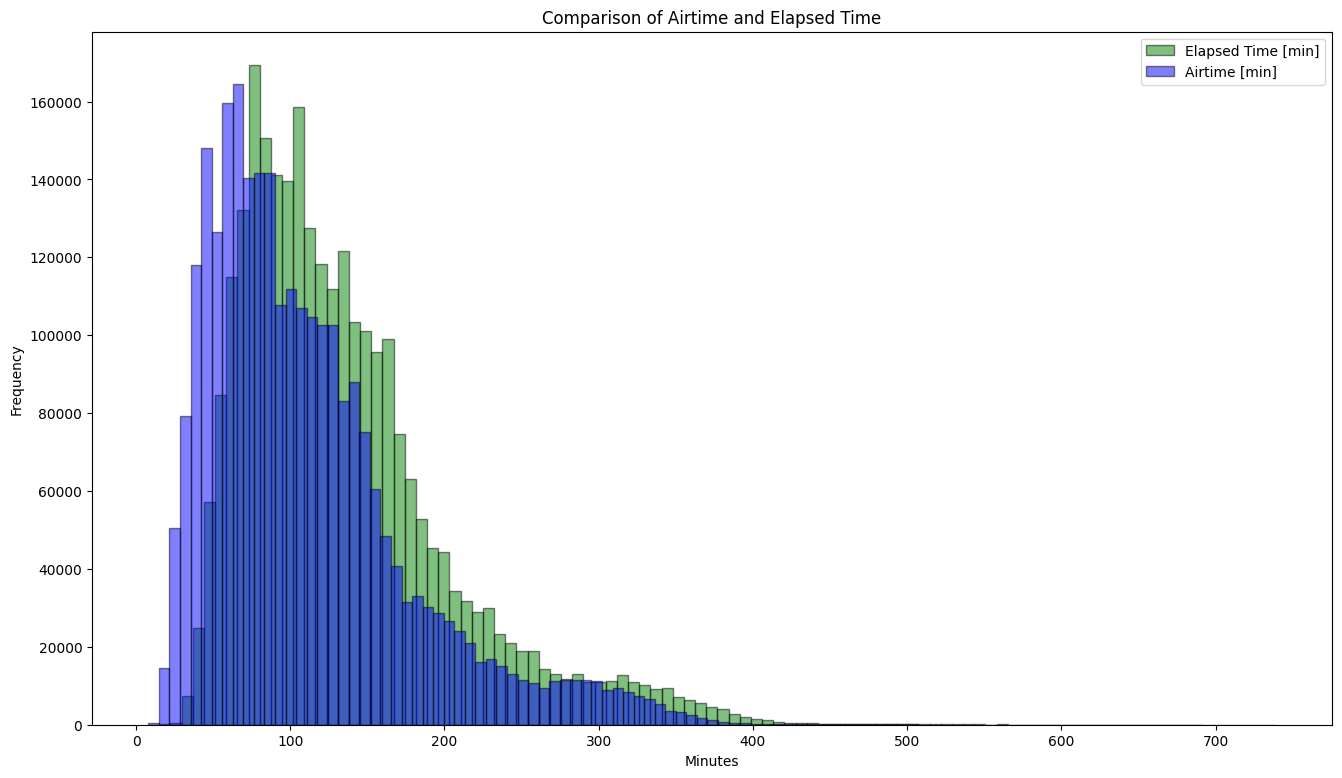

In [43]:
# Overlapping Histograms to compare airtime vs. elapsed time
plt.figure(figsize=(16, 9))

plt.hist(fl_df["ELAPSED_TIME"], bins=100, alpha=0.5, label="Elapsed Time [min]", color="green", edgecolor="black")
plt.hist(fl_df["AIR_TIME"], bins=100, alpha=0.5, label="Airtime [min]", color="blue", edgecolor="black")

plt.title("Comparison of Airtime and Elapsed Time")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

# Visualising Airtimes
---

In [44]:
# Convert from timedelta to minutes
fl_df["WOWO_AIR_TIME"] = fl_df["WOWO_AIR_TIME"].dt.total_seconds()/60

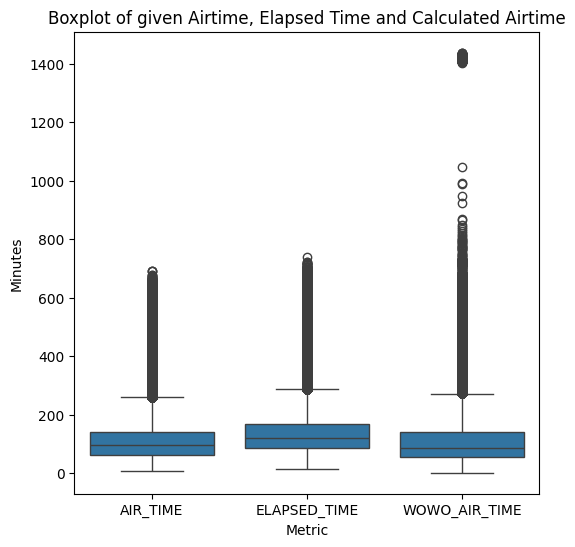

In [45]:
# Prepairing data for boxplots to take a view about outliers when it comes to flightdurations
melted_data = fl_df.melt(value_vars=["AIR_TIME", "ELAPSED_TIME", "WOWO_AIR_TIME"], 
                                         var_name="Metric", value_name="Minutes")

# Setting up the boxplots
plt.figure(figsize=(6,6))
sns.boxplot(x="Metric", y="Minutes", data=melted_data, legend=False)
plt.title("Boxplot of given Airtime, Elapsed Time and Calculated Airtime")

# Showing plot 
plt.show()

del melted_data 

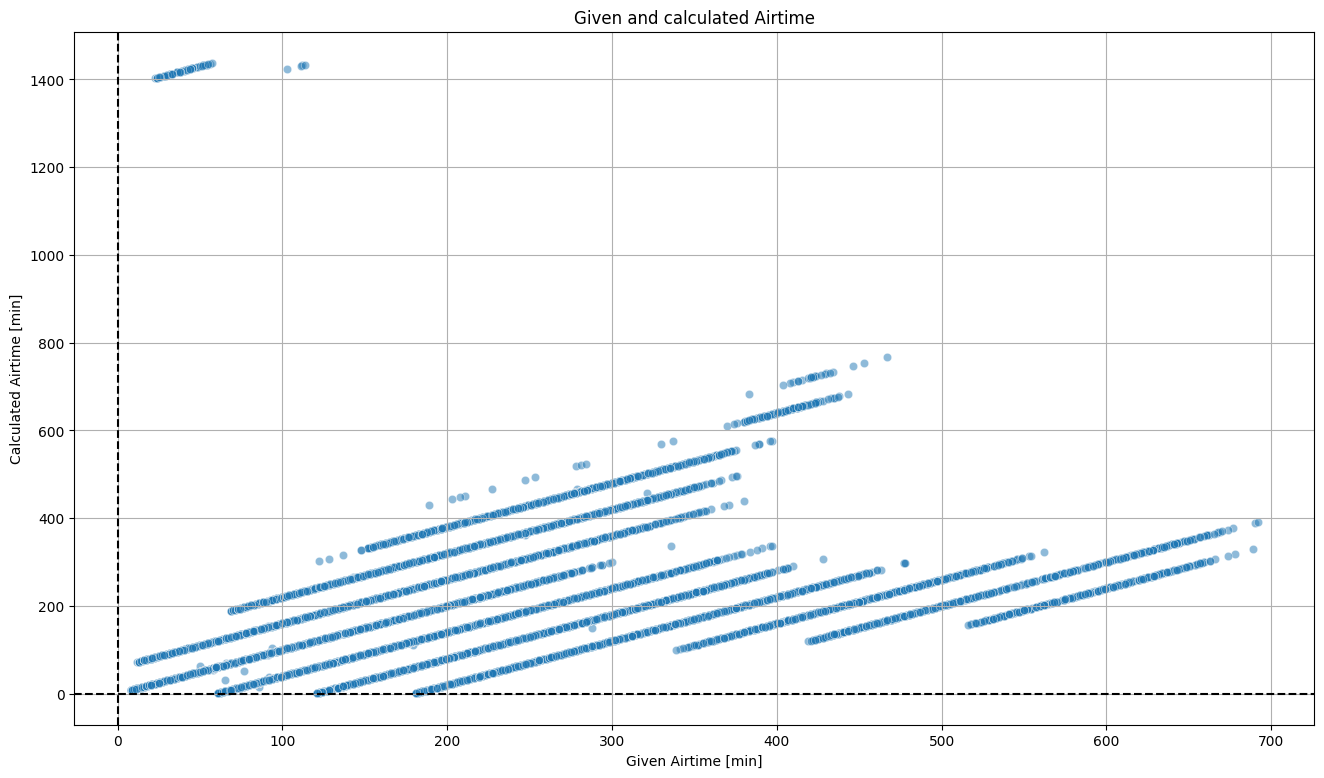

In [46]:
plt.figure(figsize=(16, 9))
sns.scatterplot(x="AIR_TIME", y="WOWO_AIR_TIME", data=fl_df, alpha=0.5)

plt.title("Given and calculated Airtime")
plt.xlabel("Given Airtime [min]")
plt.ylabel("Calculated Airtime [min]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

plt.grid(True)
plt.show()

# Machine Learning
---

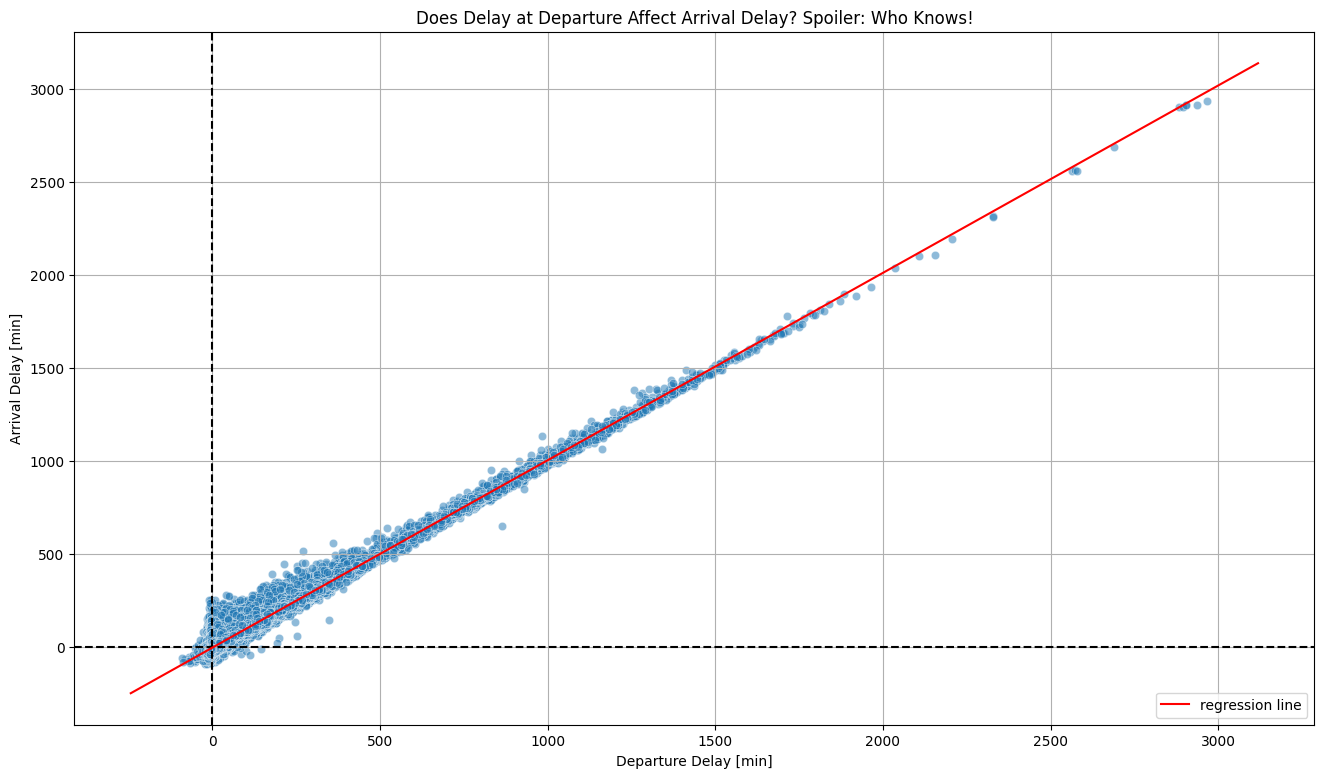

1.0077 : Slope.
-5.9012 : Intercept.
0.9262 : R²


In [47]:
# Cleaning a temporary dataframe 
df_cleaned = fl_df.dropna(subset=["DEP_DELAY", "ARR_DELAY"])

# Linear regression using scikit-learn and plotting it
X = df_cleaned["DEP_DELAY"].values.reshape(-1, 1)
Y = df_cleaned["ARR_DELAY"].values

model = LinearRegression()
model.fit(X, Y)

m = model.coef_[0]
b = model.intercept_
r_squared = model.score(X, Y)


# Checking if model checks out visually 
plt.figure(figsize=(16, 9))
sns.scatterplot(x="DEP_DELAY", y="ARR_DELAY", data=df_cleaned, alpha=0.5)

plt.title("Does Delay at Departure Affect Arrival Delay? Spoiler: Who Knows!")
plt.xlabel("Departure Delay [min]")
plt.ylabel("Arrival Delay [min]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

# Adding in regression line
x_vals = np.array(plt.gca().get_xlim())
y_vals = b + m * x_vals
plt.plot(x_vals, y_vals, color="red", label="regression line")

plt.grid(True)
plt.legend(loc="lower right")
plt.show()

# Printing information about Regression
print(f"{m:,.4f} : Slope.")
print(f"{b:,.4f} : Intercept.")
print(f"{r_squared:.4f} : R²")

del df_cleaned, X, Y, x_vals, y_vals

# Clustering
---

## DBSCAN
---
Density based spatial clustering of applications with noise

In [48]:
# Extracting data into 2D numpy array
data = fl_df[["HAVERSINE", "COR_DRIFT"]].to_numpy()

# Configuring DBSCAN parameters
dbscan = DBSCAN(eps=0.99, min_samples=2)
clusters = dbscan.fit_predict(data)

# Adding cluster labels to the dataframe
fl_df.loc[:, "DBSCANC"] = clusters

# Cleaning up memory
del data

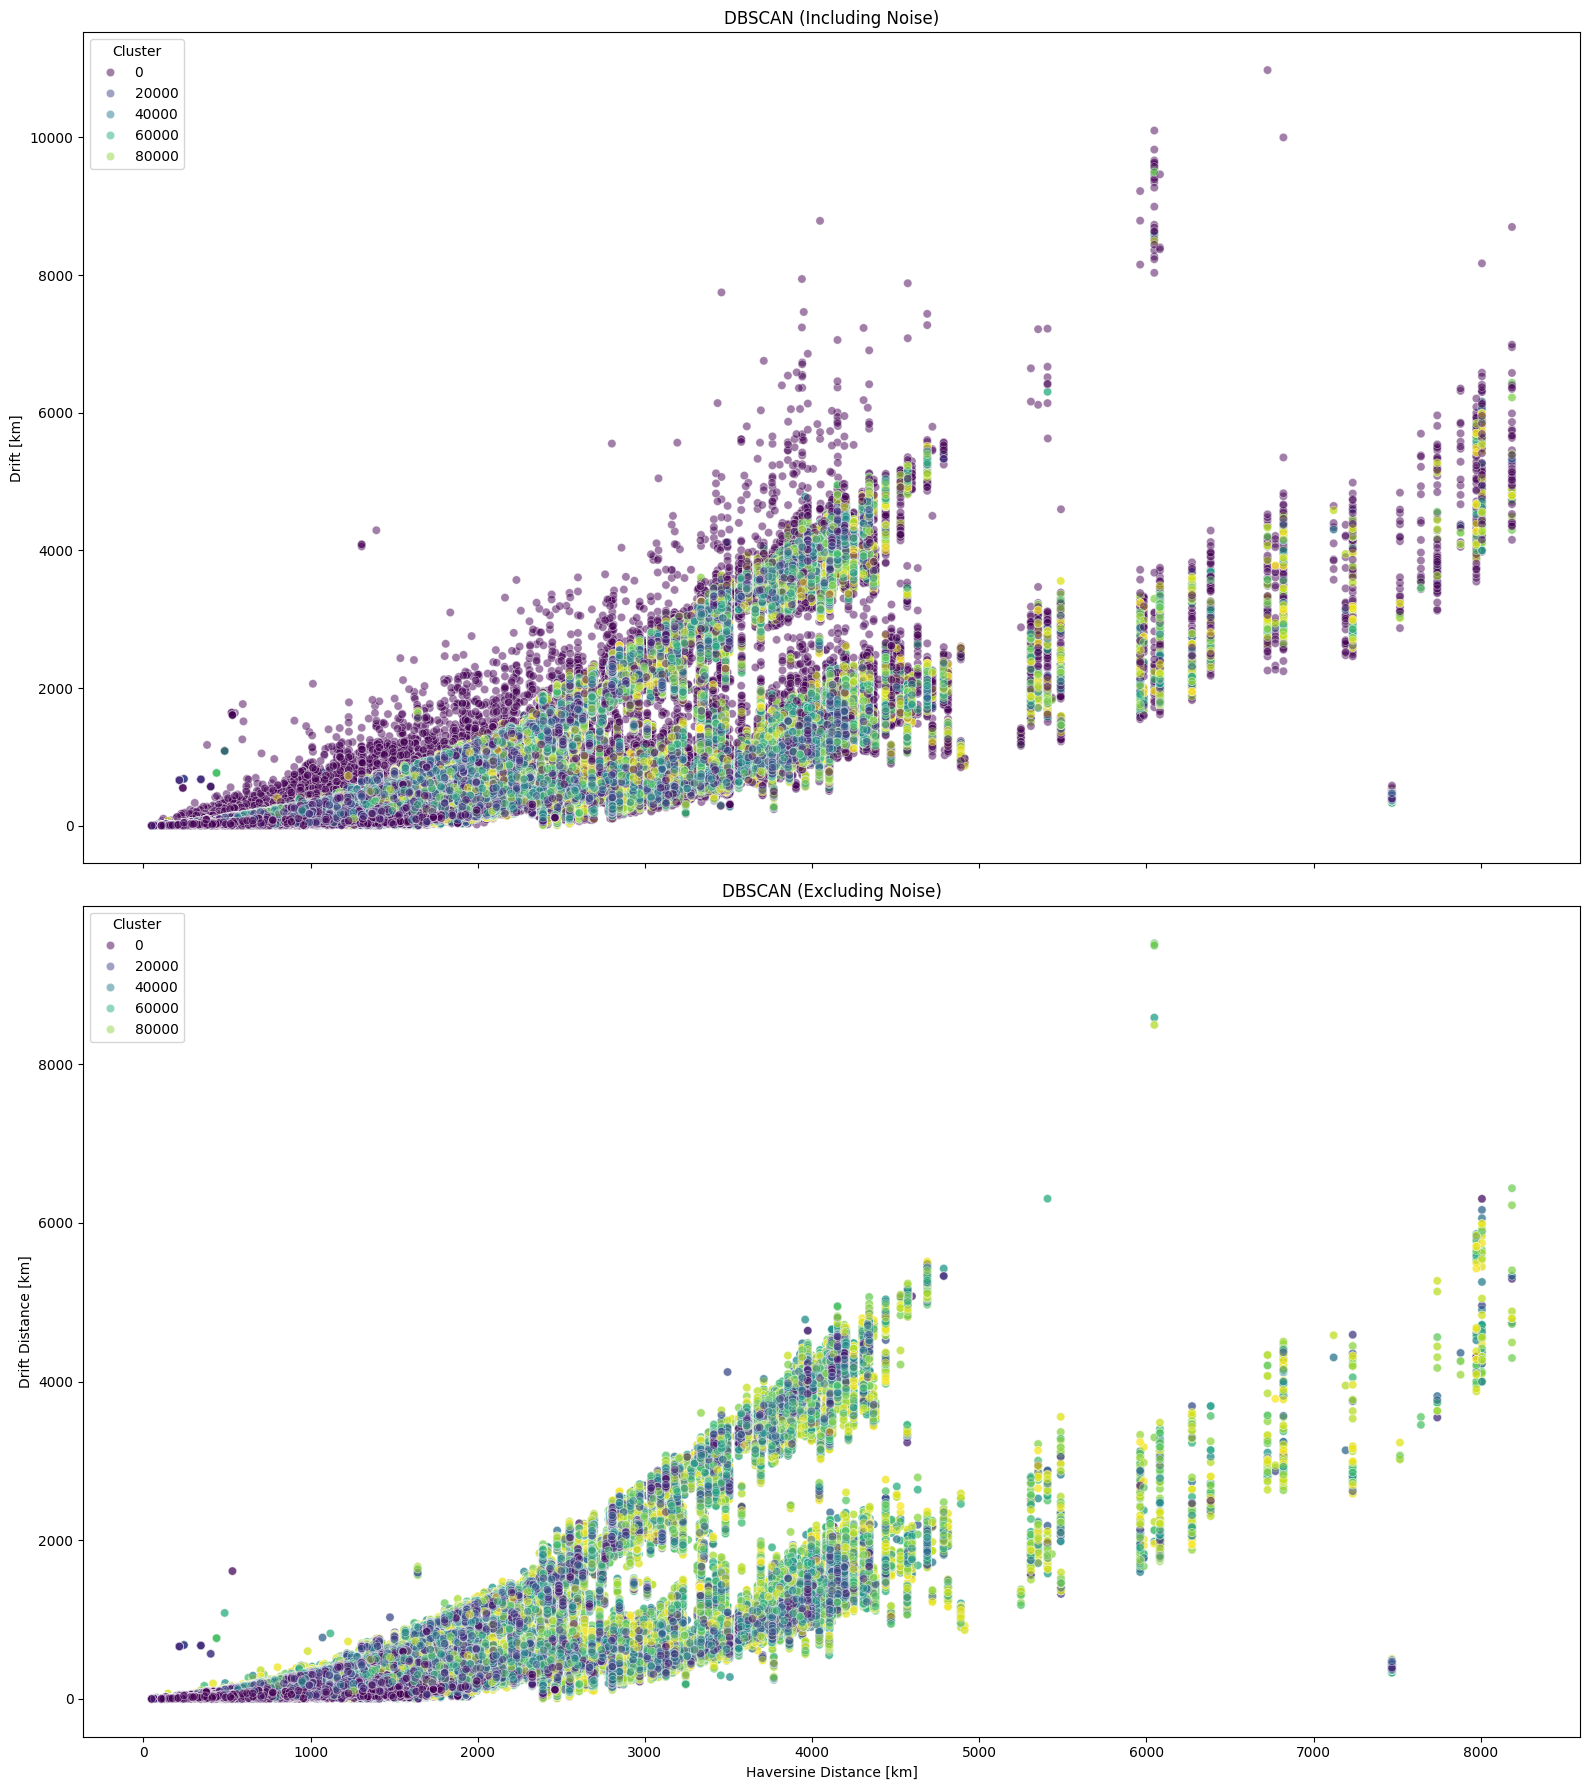

Not considered 'noise': 2689283
Considered 'noise': 40862


In [49]:
x = "HAVERSINE"
y = "COR_DRIFT"
# Creating a figure with 2 subplots, one above the other
fig, axes = plt.subplots(2, 1, figsize=(16, 18), sharex=True)

# First plot: including noise
sns.scatterplot(x=x, y=y, data=fl_df, hue="DBSCANC", palette="viridis", alpha=0.5, ax=axes[0])
axes[0].set_title("DBSCAN (Including Noise)")
axes[0].set_xlabel("Haversine Distance [km]")
axes[0].set_ylabel("Drift [km]")
axes[0].legend(loc="upper left", title="Cluster")

# Second plot: excluding noise
sns.scatterplot(x=x, y=y, data=fl_df[fl_df["DBSCANC"] != -1], hue="DBSCANC", palette="viridis", alpha=0.5, ax=axes[1])
axes[1].set_title("DBSCAN (Excluding Noise)")
axes[1].set_xlabel("Haversine Distance [km]")
axes[1].set_ylabel("Drift Distance [km]")
axes[1].legend(loc="upper left", title="Cluster")

# Adjust layout
plt.tight_layout()
plt.show()

# Print information about noise
print(f"Not considered 'noise': {len(fl_df[fl_df["DBSCANC"] != -1])}")
print(f"Considered 'noise': {len(fl_df[fl_df["DBSCANC"] == -1])}")

In [50]:
# Drop outliers (rows labeled as -1) inplace
fl_df.drop(fl_df[fl_df["DBSCANC"] == -1].index, inplace=True)

# K-Means

In [51]:
# Preprocessing for kmeans
kmeans_X = fl_df[["HAVERSINE", "COR_DRIFT"]].values

# Applying kmeans
kmeans = KMeans(n_clusters=15, n_init=20, random_state=11)  # Adjusting number of clusters
kmeans.fit(kmeans_X)
fl_df["KMEANSC"] = kmeans.labels_

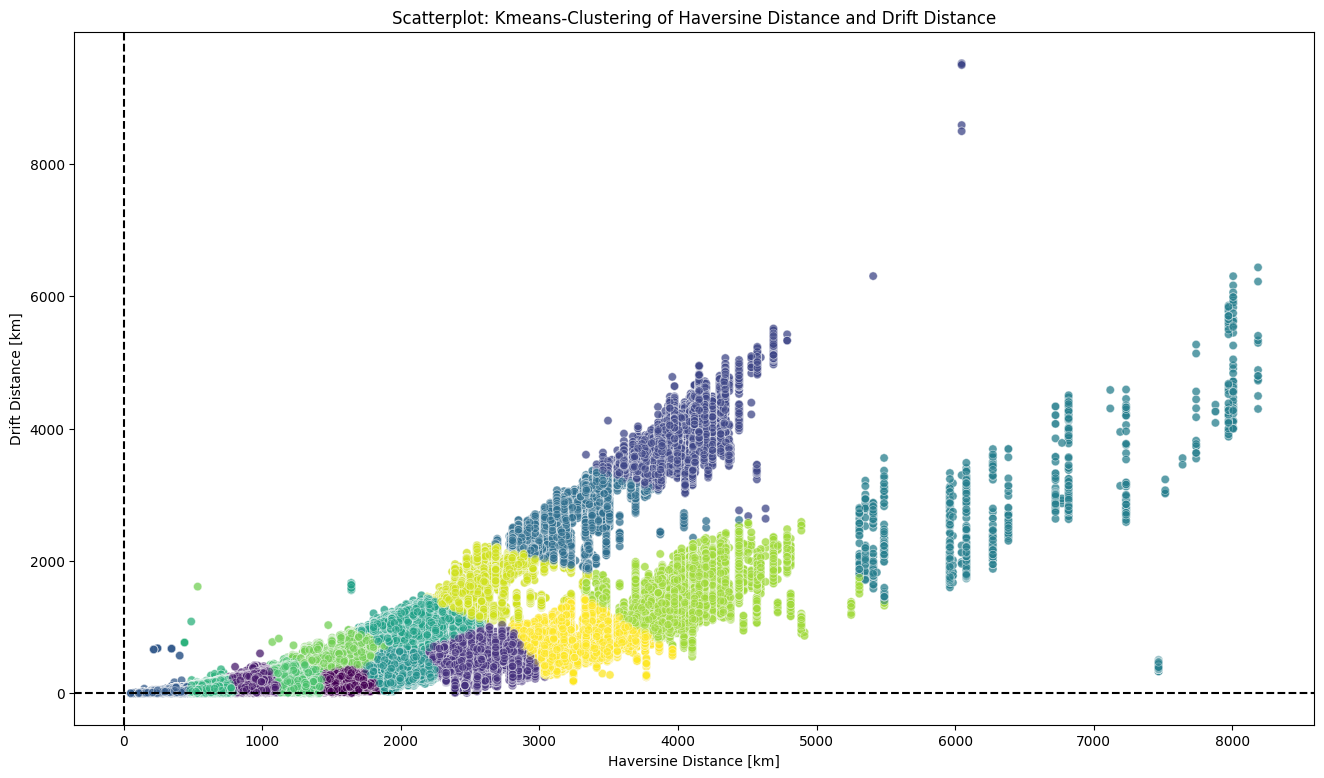

In [52]:
# Plotting kmeans
plt.figure(figsize=(16, 9))
sns.scatterplot(x="HAVERSINE", y="COR_DRIFT", c=fl_df["KMEANSC"], cmap="viridis", data=fl_df, alpha=0.5)

plt.title("Scatterplot: Kmeans-Clustering of Haversine Distance and Drift Distance")
plt.xlabel("Haversine Distance [km]")
plt.ylabel("Drift Distance [km]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

plt.show()

# Fitting Polynomial
---

In [53]:
# Fit second order polynomial
coefs = np.polyfit(fl_df["HAVERSINE"], fl_df["COR_DRIFT"], 2)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(fl_df["HAVERSINE"])

ss_res = np.sum((fl_df["COR_DRIFT"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((fl_df["COR_DRIFT"] - np.mean(fl_df["COR_DRIFT"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
poly2_x_values = np.linspace(fl_df["HAVERSINE"].min(), fl_df["HAVERSINE"].max(), 100) 
poly2_y_values = np.polyval(coefs, poly2_x_values)

print(f"{poly_r_squared:.2f}: R² of the second order polynomial.")

0.64: R² of the second order polynomial.


In [54]:
# Fit fifth order polynomial
coefs = np.polyfit(fl_df["HAVERSINE"], fl_df["COR_DRIFT"], 5)

# Calculate R²
poly = np.poly1d(coefs)
y_predictions = poly(fl_df["HAVERSINE"])

ss_res = np.sum((fl_df["COR_DRIFT"] - y_predictions) ** 2) # residual sum of squares 
ss_tot = np.sum((fl_df["COR_DRIFT"] - np.mean(fl_df["COR_DRIFT"])) ** 2) # total sum of squares

poly_r_squared = 1 - (ss_res / ss_tot)

# Setup polynomial for plot
poly5_x_values = np.linspace(fl_df["HAVERSINE"].min(), fl_df["HAVERSINE"].max(), 100)
poly5_y_values = np.polyval(coefs, poly5_x_values)

print(f"{poly_r_squared:.2f}: R² of the fifth order polynomial.")

0.67: R² of the fifth order polynomial.


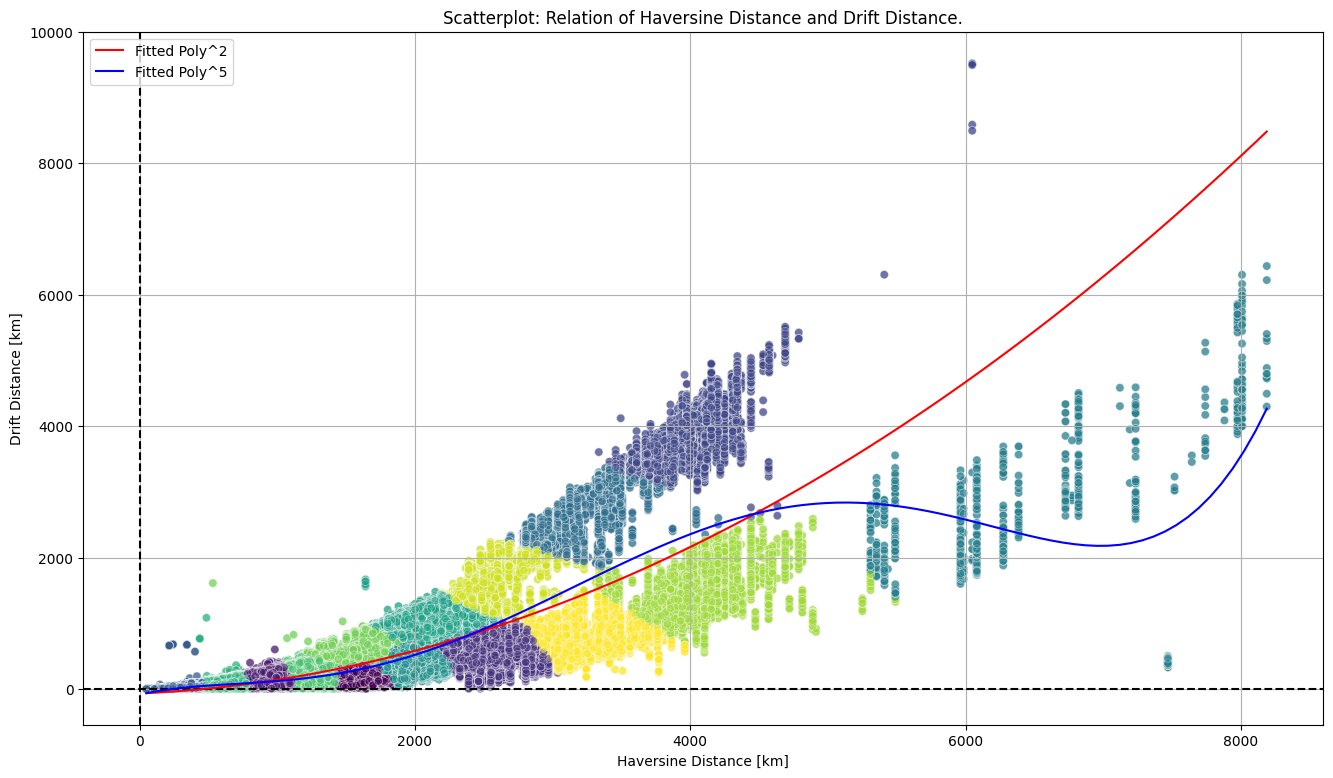

In [55]:
# Let's compare Visually
plt.figure(figsize=(16, 9))
sns.scatterplot(x="HAVERSINE", y="COR_DRIFT", c=fl_df["KMEANSC"], cmap="viridis", data=fl_df, alpha=0.5)

plt.title("Scatterplot: Relation of Haversine Distance and Drift Distance.")
plt.xlabel("Haversine Distance [km]")
plt.ylabel("Drift Distance [km]")

plt.axhline(0, color="0", linestyle="--")  # Reference line for x-axis
plt.axvline(0, color="0", linestyle="--")  # Reference line for y-axis

plt.plot(poly2_x_values, poly2_y_values, color="red", label="Fitted Poly^2")
plt.plot(poly5_x_values, poly5_y_values, color="blue", label="Fitted Poly^5")

plt.grid(True)
plt.legend(loc="upper left")
plt.show()